In [1]:
# Load data
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [3]:
print(train_targets)

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

In [4]:
# Normalizing data
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [5]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))    
    model.add(layers.Dense(64, activation='relu'))       
    model.add(layers.Dense(1))
    # mse = mean square error, mae = mean absolute error
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [6]:
# Validating using k-flod validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing flod #', i)
    val_data = train_data[i * num_val_samples : (i+1)*num_val_samples]   
    val_targets = train_targets[i * num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples], 
        train_data[(i+1)*num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples], 
        train_targets[(i+1)*num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing flod # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing flod # 1
processing flod # 2
processing flod # 3


In [7]:
print(all_scores)
print(np.mean(all_scores))

[2.0318200694452417, 2.2504095889554163, 2.940083614670404, 2.3380336962123907]
2.390086742320863


In [8]:

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing flod #', i)
    val_data = train_data[i * num_val_samples : (i+1)*num_val_samples]   
    val_targets = train_targets[i * num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples], 
        train_data[(i+1)*num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples], 
        train_targets[(i+1)*num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['mean_absolute_error']
    all_mae_histories.append(mae_history)

processing flod # 0
processing flod # 1
processing flod # 2
processing flod # 3


In [9]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

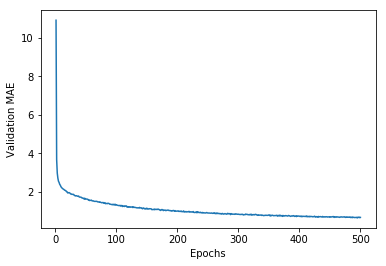

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

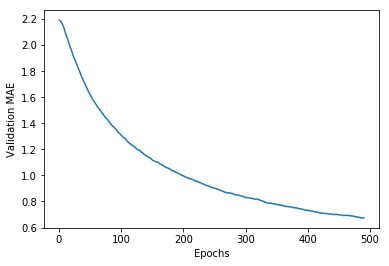

In [11]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
                

In [12]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=200, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [13]:
print(test_mae_score)

2.2958661247702206
